# Market selection by using portfolio theory

In [361]:

import os,sys,matplotlib,pandas,numpy,scipy,dateutil
import pandas as pd
import numpy as np
from pylab import *
from datetime import datetime, timedelta
import time
from statsmodels.distributions.empirical_distribution import ECDF
import sqlite3
import itertools, random
import pickle
conn = None


## Reading price data.
Connect to database first, and the slurp the data for the given markets 

In [362]:
markets = [ {'type': 'g2.2xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'c3.xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'r3.large', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'm3.medium', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'} ,
                     {'type': 'd2.8xlarge', 'region': 'us-east-1', 'AZ': 'a', 'OS': 'Linux'}
                     ]

In [363]:
str(instance_string(markets[0]))

'us-east-1a-Linux-g2.2xlarge'

In [364]:
def init_db_connection() :
    global conn
    conn = sqlite3.connect('/home/prateeks/spot_prices_2015/aws.db')
    return 

init_db_connection();


OperationalError: unable to open database file

In [365]:
print conn

None


In [366]:
def instance_to_MarketId(i) :
    """ The database table names or the file names  """
    osname = {'Linux':'Linux/UNIX'}
    return i['region']+i['AZ']+'-'+osname[i['OS']]+'-'+i['type']


In [367]:
def instance_string(i):
    return i['region']+i['AZ']+'-'+ i['OS']+'-'+i['type']

In [368]:
def read_data_sqlite(instance , mktstring=None, months=['201503','201504','201505','201506','201507','201508'],pickle_data=True):
    global conn
    table_name_base='AKIAJXNAQH5WHJFPNCXA_' # '201503'
    if mktstring == None:
        mktstring = instance_to_MarketId(instance)
    output=[]
    ondem=[]
    ondemtable = 'on_demand_price'
    #Need to remove avail zone from mkt string argh!
   #TODO: function for converting to the on-demand string 
    ondem_mktstring = mktstring.replace('a-','-')
    ondem_mktstring = ondem_mktstring.replace('/UNIX','')
    q2 = 'SELECT SpotPrice FROM {} WHERE MarketId=\'{}\' ;'.format(ondemtable, ondem_mktstring)
    d2 = conn.execute(q2)
    ondem = d2.fetchall()

    for month in months :
        table_name = table_name_base+month
        query='SELECT Timestamp, SpotPrice FROM {} WHERE MarketId=\'{}\' ;'.format(table_name, mktstring)
        #print query
        d = conn.execute(query)
        output.extend(d.fetchall())
    if pickle_data is True :
        fname = instance_string(instance)+'.pickle'
        with open(fname, 'w') as f :
            pickle.dump((instance, output, ondem[0][0]), f)
    return output, ondem[0][0]


In [369]:
def get_spot_data(markets, from_pickle=False):
    """
    markets is a list of dictionaries. Return [(mkt,on-demprice,[(t,spot-price)])]
    """
    global conn
    data = []
    
    if from_pickle is False:
        init_db_connection()
        #c3.xlarge seems volatile
        for i in markets :
            ts, ondem = read_data_sqlite(i)
            spot = [(time.mktime(dateutil.parser.parse(t).timetuple()), float(f)) for (t,f) in ts]
            nspot = np.array(spot)
            data.append((i, float(ondem), nspot))
    else : 
        #Read all the pickle files from the directory and call get_pickled_data
        for file in os.listdir('.'):
            if file.endswith(".pickle") :
                with open(file,'r') as f:
                    (i, ts, ondem) = get_picked_data(f)
                    spot = [(time.mktime(dateutil.parser.parse(t).timetuple()), float(f)) for (t,f) in ts]
                    nspot = np.array(spot)
                    data.append((i, float(ondem), nspot))

    return data


In [370]:
def get_picked_data(f):
    """ Get pickled data from a file. Return (instance, ts, ondem) tuple. """
    (instance, ts, ondem) = pickle.load(f)
    return (instance, ts, ondem)
    

In [371]:
ls

all-cdf.py               testr.R
Bidding_1.ipynb          time_series_1.ipynb
Bidding_2.ipynb          Untitled0-Copy0_1.ipynb
Correlation-Copy0.ipynb  Untitled0.ipynb
Correlation.ipynb        Untitled1.ipynb
cvtest.py                Untitled2.ipynb
cvtest.py~               us-east-1a-Linux-c3.xlarge.pickle
ft-mechanisms.py         us-east-1a-Linux-d2.8xlarge.pickle
overyears.py             us-east-1a-Linux-g2.2xlarge.pickle
parr_ex_price.py         us-east-1a-Linux-m3.medium.pickle
README.md                us-east-1a-Linux-r3.large.pickle
spike_correlation.ipynb  var-risk.ipynb
spot_analysis.py         years.ipynb
spotfail.py*


In [372]:
data = get_spot_data(markets, from_pickle=True)

In [373]:
data[2]

({'AZ': 'a', 'OS': 'Linux', 'region': 'us-east-1', 'type': 'd2.8xlarge'},
 5.52,
 array([[  1.42780176e+09,   5.60000000e-01],
        [  1.42783420e+09,   5.63500000e-01],
        [  1.42783820e+09,   5.63900000e-01],
        ..., 
        [  1.44108291e+09,   6.02000000e-01],
        [  1.44108307e+09,   6.07300000e-01],
        [  1.44108340e+09,   5.97600000e-01]]))

In [374]:
def get_prices_only(d, normalized=False):
    """ For a given 3-tuple, return an array of prices. Strip the timestamps
    """
    ondem_price = d[1]
    spot_prices = d[2][:,1]
    
    if normalized:
        return spot_prices/ondem_price  #time, price
    else :
        return spot_prices
    
#normalized_price(data[0])

In [375]:
np.mean(get_prices_only(data[2]))

0.99142422038457712

In [419]:
def bid_transform(d):
    """Given a bid, execute some transformation over the prices."""
    ondem_price = d[1]
    spot_prices = d[2][:,1]
    maxprice = 100*ondem_price
    bid = ondem_price 
    spot_prices[spot_prices >= bid] = maxprice #Amplify the price spike
    spot_prices = maxprice - spot_prices  #Price => Profits transformation
    #Not sure we want to normalize this to the on-demand price? Hmm...
    #Normalizing by 10*on-demand price yields returns which are monotonically *DECREASING* with risk
    #We want increasing returns with increasing risk, so turn off the normalization
    return spot_prices
    


In [420]:
prices = get_prices_only(data[0])

In [421]:
def get_transformed_prices(d, transform="bid"):
    td = [] #List of transformed prices
    instances = []
    for di in d:
        if transform=="bid":
            td.append(bid_transform(di))
        elif transform=="plain":
            td.append(get_prices_only(di))
        instances.append(di[0])
    min_length = min([len(a) for a in td])

    print min_length
    return (instances, np.vstack([a[:min_length] for a in td]) )


In [422]:
(instances, dt) = get_transformed_prices(data, transform="bid")
import scipy.stats

3755


In [423]:
scipy.stats.describe(data[2][2][:,1])

(10037,
 (0.56000000000000005, 552.0),
 19.074596981169673,
 9747.0918701594546,
 5.212902557901325,
 25.174746049931798)

## Portfolio construction starts here
So far we have read in the spot prices, applied the transforms, and computed the covariance matrix. Now its time for the actual portfolio creation.


In [424]:
import cvxopt as opt
from cvxopt import blas, solvers
%matplotlib inline

In [425]:
solvers.options['show_progress'] = False

In [426]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [427]:
num_mkts = len(instances)

In [428]:
print num_mkts

5


In [429]:
def eval_portfolio(dt):
    p = np.asmatrix(np.mean(dt,axis=1))
    w = np.asmatrix(rand_weights(dt.shape[0]))
    C = np.asmatrix(np.cov(dt))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    print mu, sigma
    
    return mu, sigma

In [430]:
n_portfolios = 50
means, stds = np.column_stack([
    eval_portfolio(dt) 
    for _ in xrange(n_portfolios)
])


[[ 162.31374549]] [[ 32.66096697]]
[[ 87.36718894]] [[ 17.10029709]]
[[ 101.36724791]] [[ 17.58753452]]
[[ 46.59646091]] [[ 3.95557379]]
[[ 47.25158614]] [[ 6.29756495]]
[[ 112.01388145]] [[ 24.2362321]]
[[ 298.52584752]] [[ 68.32654978]]
[[ 141.84083173]] [[ 30.83001834]]
[[ 139.73308813]] [[ 30.93468604]]
[[ 116.29304442]] [[ 20.05330044]]
[[ 97.21763742]] [[ 18.62851862]]
[[ 164.34491402]] [[ 34.8333082]]
[[ 85.29648666]] [[ 11.74579693]]
[[ 141.67370333]] [[ 29.93372859]]
[[ 71.36474648]] [[ 11.95041589]]
[[ 74.5169154]] [[ 10.29030295]]
[[ 73.97346051]] [[ 11.45831702]]
[[ 51.6746222]] [[ 7.93322602]]
[[ 232.3992602]] [[ 52.18374009]]
[[ 65.51880391]] [[ 9.00883413]]
[[ 124.95495079]] [[ 26.17064756]]
[[ 95.37989367]] [[ 18.82118509]]
[[ 139.77711963]] [[ 27.83240844]]
[[ 157.11353573]] [[ 32.00616866]]
[[ 25.13980995]] [[ 1.47791122]]
[[ 107.68191437]] [[ 22.14833057]]
[[ 152.55298413]] [[ 32.14592669]]
[[ 98.60117057]] [[ 16.98852262]]
[[ 140.35097381]] [[ 28.37406497]]
[[ 164.6

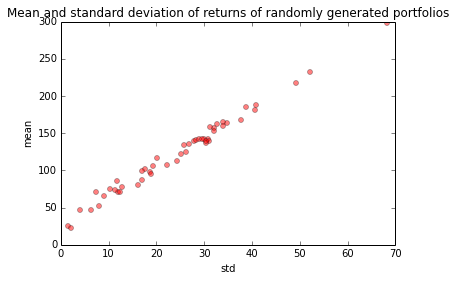

In [431]:
plt.plot(stds, means, 'o', markersize=5, color='r', alpha=0.5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')


In [435]:
def optimal_portfolio(returns):
    n = len(returns)
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    N = 10
    #mus = [1.01**(5.0 * t/N - 1.0) for t in range(N)]
    mus = [0.05+(0.05*t) for t in range(150)]
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    #returns = np.asmatrix(returns)   
    returns = opt.matrix(returns)
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    print "S, Covariance: ", S.size, S
    print "Returns: ", returns.size
    print "pbar: ", pbar.size, pbar
    print "G: ", G.size
    print "h: ", h.size
    print "A: ", A.size
    print "b: ", b.size
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios=[]
    for mu in mus:
        try:
            result = solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
            #Result is presumably the weights for a given mu
            portfolios.append(result)
        except :
            print "BAD MU ", mu
            pass
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = np.zeros(n)
    try:
        wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    except:
        print "NOT ABLE TO CALCULATE WEIGHT"
    return np.asarray(wt), returns, risks

In [436]:
weights, returns, risks = optimal_portfolio(dt)

S, Covariance:  (5, 5) [ 6.57e+00 -2.21e-01  5.21e+01 -1.50e-01 -5.03e-02]
[-2.21e-01  1.18e+01 -1.33e+01  5.11e-01 -1.11e-01]
[ 5.21e+01 -1.33e+01  1.55e+04 -5.07e+00 -4.73e+00]
[-1.50e-01  5.11e-01 -5.07e+00  2.90e+00 -7.43e-02]
[-5.03e-02 -1.11e-01 -4.73e+00 -7.43e-02  1.01e+01]

Returns:  (5, 3755)
pbar:  (5, 1) [ 2.06e+01]
[ 1.68e+01]
[ 5.21e+02]
[ 6.22e+00]
[ 6.48e+01]

G:  (5, 5)
h:  (5, 1)
A:  (1, 5)
b:  (1, 1)
NOT ABLE TO CALCULATE WEIGHT


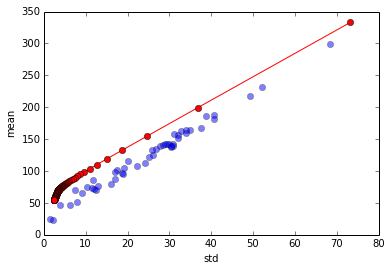

In [437]:
plt.plot(stds, means, 'o',alpha=0.5)
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'r-o')

In [12]:
def my_covariance(x,y):
    """
    This yields similiar results to
    pd.Series(x).cov(pd.Series(y)) """
    xbar = x.mean()
    ybar = y.mean()
    x = x-xbar
    y = y-ybar
    n = min(x.shape[0], y.shape[0])
    x = x[:n-1]
    y = y[:n-1]
    cov = (x*y)
    cov = np.sum(cov)/(n-1)
    print cov
    return cov


In [114]:
print dt

[[ -6.4348  -6.435   -6.4349 ...,  -6.4347  -6.4351  -6.4354]
 [ -2.0676  -2.0679  -2.0676 ...,  -2.0679  -2.0654  -2.0679]
 [ -1.7281   0.      -1.733  ...,  -1.7318  -1.7313  -1.7331]
 [-54.64   -54.6365 -54.6361 ..., -54.6354 -54.6348 -54.6354]
 [  0.       0.       0.     ...,  -0.653   -0.653   -0.653 ]]


In [13]:
my_covariance(x,y)

-8.02333628098e-05


-8.0233362809846391e-05

In [14]:
pd.Series(x).cov(pd.Series(y))

-8.0003161504696132e-05

In [16]:

d0=data[0]
d1=data[1]
print d0

({'OS': 'Linux', 'region': 'us-east-1', 'AZ': 'a', 'type': 'g2.2xlarge'}, 0.65, array([[  1.42611080e+09,   6.52000000e-02],
       [  1.42611117e+09,   6.50000000e-02],
       [  1.42611153e+09,   6.51000000e-02],
       ..., 
       [  1.44108320e+09,   1.25300000e-01],
       [  1.44108337e+09,   1.18500000e-01],
       [  1.44108353e+09,   1.14200000e-01]]))


In [17]:
s0 = pd.Series(d0[2][:,1], index=d0[2][:,0])